In [6]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Optional

In [4]:
api = wandb.Api()


In [25]:
seq2seq_urls = {"Base 2": "mnqsex62", "Base 5": "nky517vj", "Base 10": "bhxuacv2", "Base 20": "2o3e5sjs", "Base 40": "rhnanmy2", "Base 64": "uffj61a9"}
#whvq0pm4

In [26]:
class DataProcessor:
    def __init__(self, api: wandb.Api):
        self.api = api
    
    def get_accuracies(self, run_path: str) -> Tuple[pd.Series, pd.Series]:
        """Fetch both validation and training accuracy data from W&B."""
        run = self.api.run("philliplakaschus/grokking/" + run_path)
        
        # Get history with both accuracy metrics
        history = list(run.scan_history([
            'Optimization Steps', 
            'validation_in_domain/accuracy',
            'training/accuracy'
        ]))
        if not history:
            raise ValueError(f"No data found for run: {run_path}")
        
        # Create DataFrame and convert to Series
        df = pd.DataFrame(history)
        validation = pd.Series(
            df['validation_in_domain/accuracy'].values,
            index=df['Optimization Steps']
        )
        training = pd.Series(
            df['training/accuracy'].values,
            index=df['Optimization Steps']
        )
        return validation, training
    
    @staticmethod
    def apply_ema(series: pd.Series, alpha: float = 0.5) -> pd.Series:
        """Apply Exponential Moving Average smoothing."""
        return series.ewm(alpha=alpha, adjust=False).mean()

def plot_seq2seq_comparison(api: wandb.Api, seq2seq_urls: Dict[str, str], n_steps: int = 4000):
    """Create a single plot comparing validation and training accuracy across different bases."""
    processor = DataProcessor(api)
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(16, 8), dpi=150)
    
    # Color palette for different bases
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Plot each base's validation and training accuracy
    for (base_name, url), color in zip(seq2seq_urls.items(), colors):
        # Fetch and process data
        validation_accuracy, training_accuracy = processor.get_accuracies(url)
        smoothed_validation = processor.apply_ema(validation_accuracy)
        smoothed_training = processor.apply_ema(training_accuracy)
        
        # Plot up to n_steps
        validation_data = smoothed_validation[smoothed_validation.index <= n_steps]
        training_data = smoothed_training[smoothed_training.index <= n_steps]
        
        # Plot validation (solid) and training (dashed) lines
        ax.plot(validation_data.index, validation_data.values,
                color=color, linewidth=1.5, linestyle='--', label=f'{base_name} (val)')
        ax.plot(training_data.index, training_data.values,
                color=color, linewidth=1.5, label=f'{base_name} (train)')
    
    # Style plot
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('#ffffff')
    ax.grid(True, which='major', linestyle='--', alpha=0.7, color='#cccccc')
    ax.grid(True, which='minor', linestyle=':', alpha=0.4, color='#cccccc')
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    
    # Set logarithmic x-axis
    ax.set_xscale('log')
    
    # Labels and title
    ax.set_xlabel('Optimization Steps (log scale)', fontsize=16, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=16, fontweight='bold')
    ax.set_title('Seq2Seq Training and Validation Accuracy Comparison\nAcross Different Bases', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Legend and formatting
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
             borderaxespad=0, frameon=True, fancybox=True,
             shadow=True, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_ylim(-0.05, 1.05)
    
    plt.tight_layout()
    return fig, ax

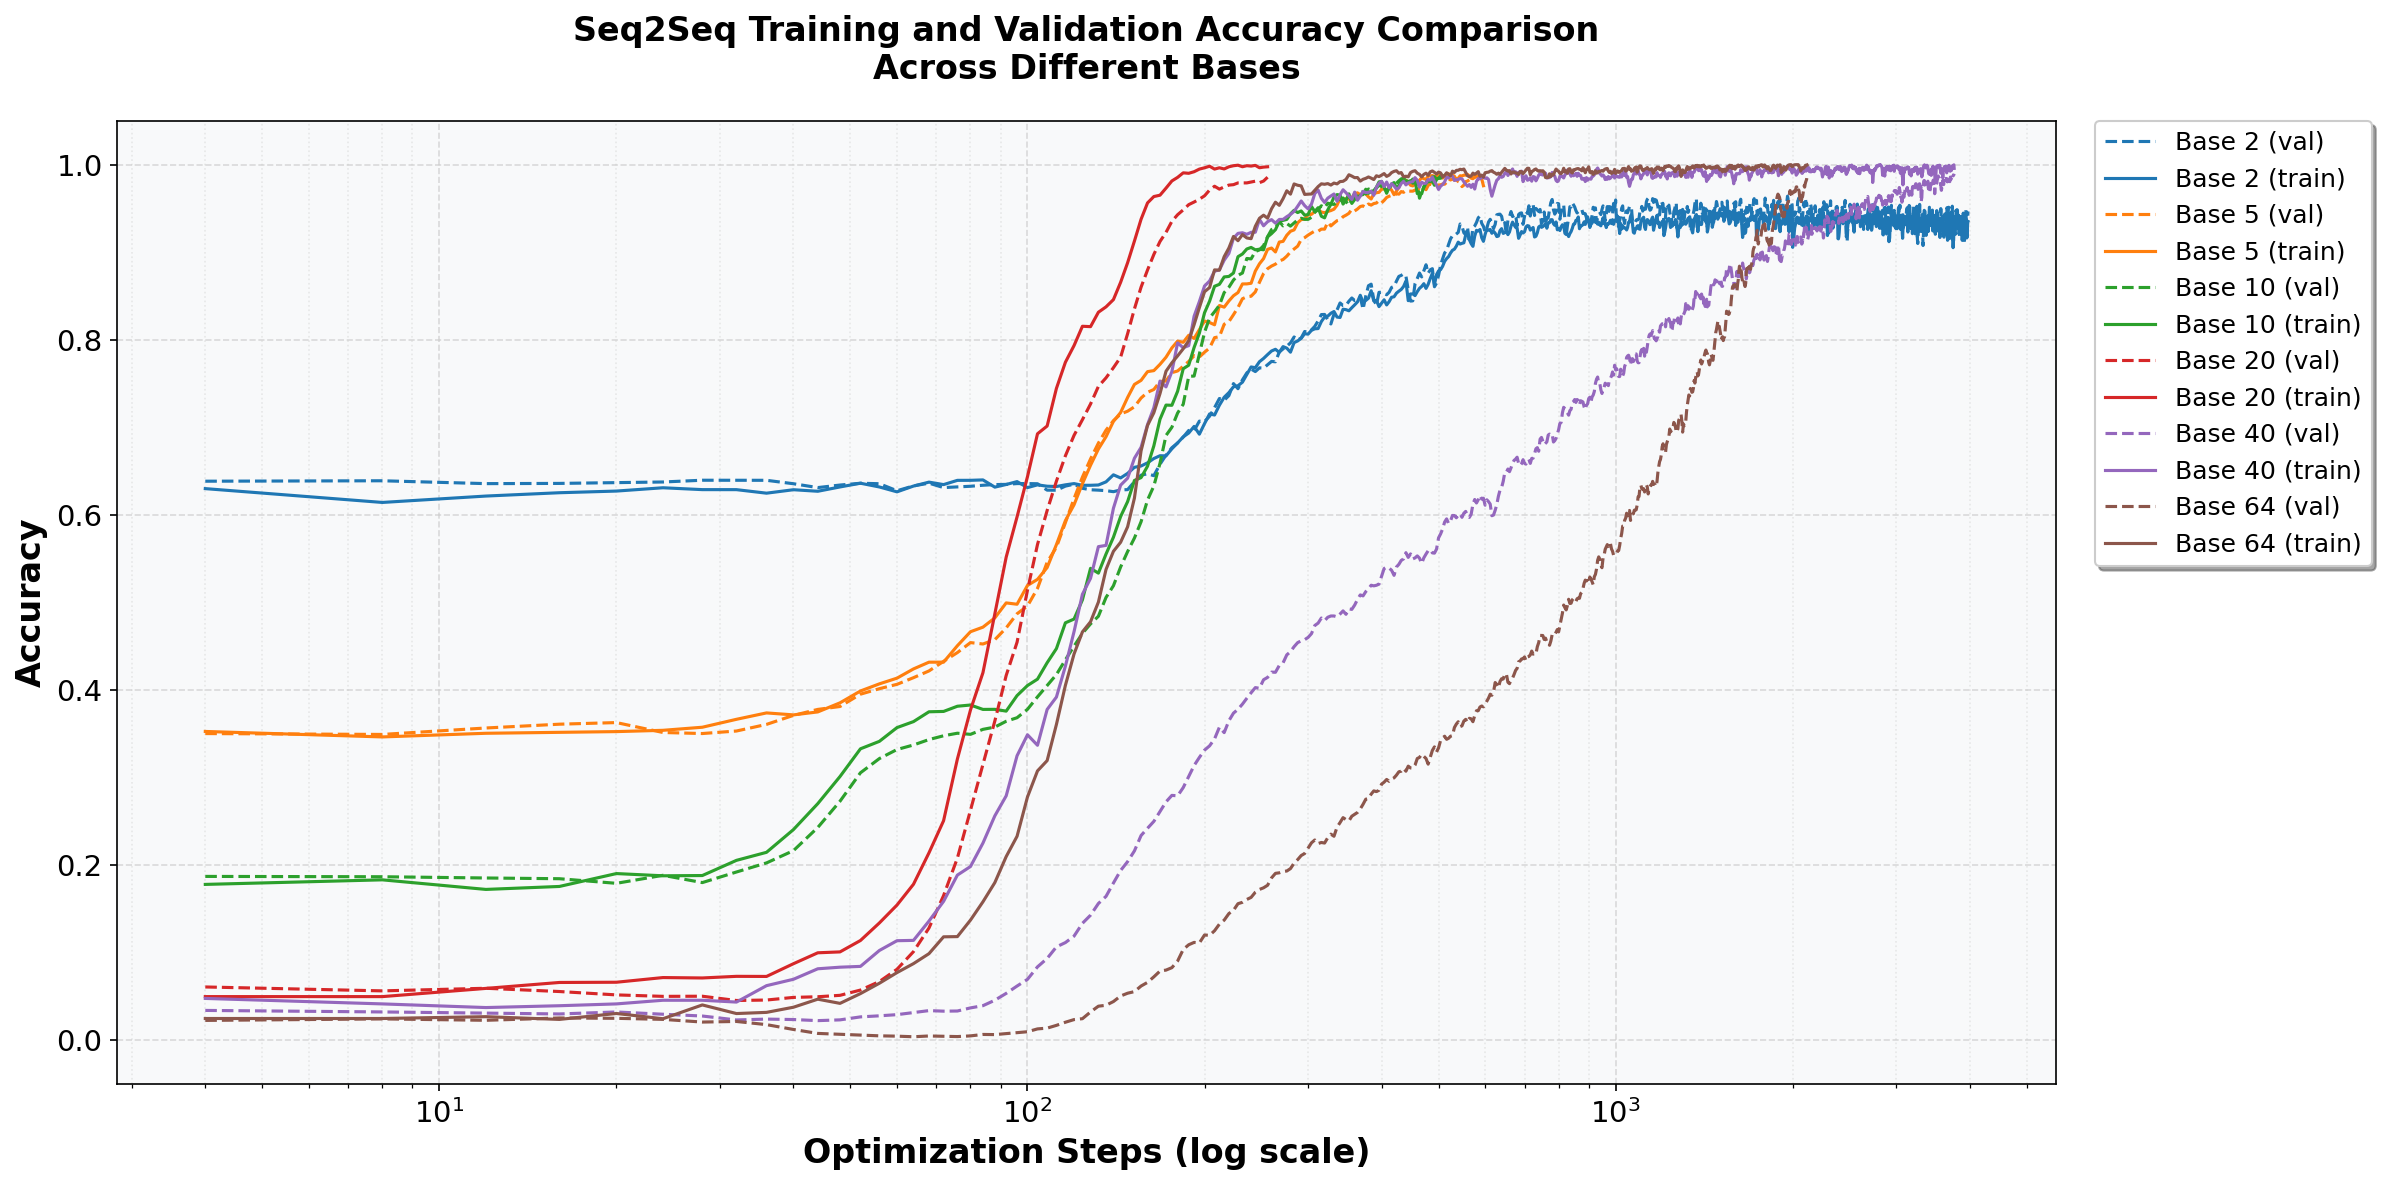

In [27]:
# Create and display the plot
fig, ax = plot_seq2seq_comparison(api, seq2seq_urls)
plt.show()